[20220924]

# 2. Model 4

After Preparation ready. Build and train the model in here. its using two layers LSTM. with data gen2

## Goal
Find patterns on the features for target

## Plan
Checklist what will be done on the notebook :

        [ ] Get Data
        [ ] Modelling
        [ ] Evaluation

In [2]:
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import os
import joblib
import sys
sys.path.insert(1,'../../src/')


In [3]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import metrics, optimizers
import keras
import tensorflow as tf
from keras.models import load_model

from sklearn.model_selection import train_test_split

In [4]:
with open("../../config.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

PATH_RAW = config['path']['raw']
PATH_INTERIM = config['path']['interim']
PATH_PROCESSED = config['path']['processed']
# PATH_MODEL = config['path']['artifact']+os.getcwd().split('\\')[-1]+'/'
PATH_MODEL = config['path']['artifact']+'iteration_3'+'/'
PATH_UDF = config['path']['udf']

In [5]:
%matplotlib inline

## Get Data

In [6]:
Xt, yt, Xo, yo = joblib.load(PATH_INTERIM+'feat_target_gen2_iter3.pkl')
Xt = Xt.astype("float32")
yt = yt.astype("float32")

Xo = Xo.astype("float32")
yo = yo.astype("float32")

In [7]:
Xt.shape

(403051, 10, 1)

In [8]:
yt.shape

(403051, 1)

In [9]:
SEQ = Xt.shape[1]

In [10]:
## not the best way to split time series dataset
x_tr, x_test, y_tr, y_test = train_test_split(
    Xt, yt, test_size=0.25, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(
    x_tr, y_tr, test_size=0.2, random_state=42)

## Model

In [11]:
# os.environ["CUDA_VISIBLE_DEVICES"] 

In [12]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [13]:
mod_ts = Sequential()
# mod_ts.add(LSTM(5, input_shape=(SEQ, 1)))
mod_ts.add(LSTM(256, input_shape=(SEQ, 1), return_sequences=True))
mod_ts.add(LSTM(128))
mod_ts.add(Dense(64))
mod_ts.add(Dense(16))
mod_ts.add(Dense(8))
mod_ts.add(Dense(1))


In [14]:
mod_ts.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 256)           264192    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 470,753
Trainable params: 470,753
Non-trainable params: 0
__________________________________________________

In [15]:
early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',mode='min', patience=6) 

check_p = keras.callbacks.ModelCheckpoint(
        filepath=PATH_MODEL+'ws_data_model4_iter3.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True)


# # initial_learning_rate * decay_rate ^ (step / decay_steps)
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     0.0003,
#     decay_steps=15,
#     decay_rate=0.4,
#     staircase=True)


opt = tf.keras.optimizers.Adam(learning_rate=0.0002)

mod_ts.compile(loss='mean_squared_error', optimizer=opt, metrics=[
        tf.keras.metrics.RootMeanSquaredError(name='the_rmse'),
        tf.keras.metrics.MeanAbsolutePercentageError(name='the_mape'),
    ])

In [16]:
history = mod_ts.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[early_stop,check_p]
)

Epoch 1/50
1890/1890 [==============================] - 26s 14ms/step - loss: 0.7012 - the_rmse: 0.8374 - the_mape: 110810.6484 - val_loss: 0.6899 - val_the_rmse: 0.8306 - val_the_mape: 66009.5391
Epoch 2/50
1890/1890 [==============================] - 25s 13ms/step - loss: 0.6454 - the_rmse: 0.8034 - the_mape: 87590.6484 - val_loss: 0.6428 - val_the_rmse: 0.8017 - val_the_mape: 96219.5312
Epoch 3/50
1890/1890 [==============================] - 25s 13ms/step - loss: 0.6221 - the_rmse: 0.7887 - the_mape: 77287.4453 - val_loss: 0.6317 - val_the_rmse: 0.7948 - val_the_mape: 57970.5742
Epoch 4/50
1890/1890 [==============================] - 25s 13ms/step - loss: 0.6116 - the_rmse: 0.7821 - the_mape: 63410.2773 - val_loss: 0.6221 - val_the_rmse: 0.7887 - val_the_mape: 62571.0977
Epoch 5/50
1890/1890 [==============================] - 25s 13ms/step - loss: 0.6033 - the_rmse: 0.7767 - the_mape: 64457.0820 - val_loss: 0.6180 - val_the_rmse: 0.7861 - val_the_mape: 67320.0078
Epoch 6/50
1890/189

## Eval

<AxesSubplot:>

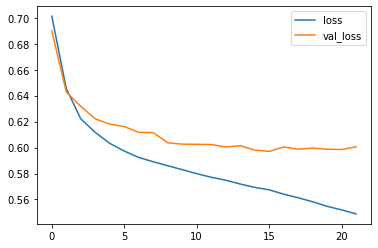

In [17]:
df_epoch_hist = pd.DataFrame(history.history)
df_epoch_hist[['loss','val_loss']].plot()

In [18]:
# depd = {'auc_1' : metrics.AUC}
model_load = load_model(PATH_MODEL + 'ws_data_model4_iter3.h5',compile=False)

In [19]:
model_load.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 256)           264192    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 470,753
Trainable params: 470,753
Non-trainable params: 0
__________________________________________________

In [20]:
model_load.compile(loss='mean_squared_error', optimizer=opt, metrics=[
        tf.keras.metrics.RootMeanSquaredError(name='the_rmse'),
        tf.keras.metrics.MeanAbsolutePercentageError(name='the_mape'),
    ])

In [21]:
model_load.evaluate(x_test,y_test)

3149/3149 [==============================] - 18s 6ms/step - loss: 0.5777 - the_rmse: 0.7601 - the_mape: 110668.3125


[0.5777102112770081, 0.7600725293159485, 110668.3125]

In [22]:
model_load.evaluate(Xo,yo)

1250/1250 [==============================] - 8s 7ms/step - loss: 0.4532 - the_rmse: 0.6732 - the_mape: 130984.5312


[0.4531659483909607, 0.6731759905815125, 130984.53125]